In [1]:
# Headers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp

from astropy.io import fits
from astropy.table import Table, Column

import treecorr

# Input Cl's

In [2]:
def read_cl():
    l = np.loadtxt('../data/Buzzard_data/Cell_halomodel.dat', usecols=(0))
    cl = np.loadtxt('../data//Buzzard_data/Cell_halomodel.dat', usecols=(1))
    return l, cl

l , cl = read_cl()

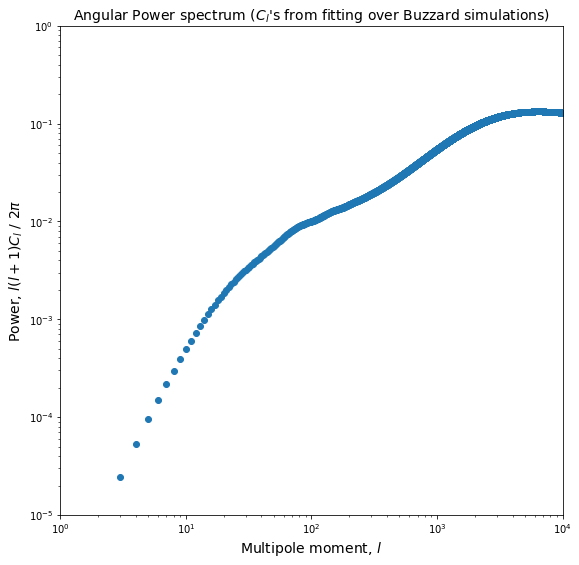

In [3]:
plt.figure(figsize=(9,9))

plt.scatter(l, l*(l+1)*cl/(2*np.pi))
plt.yscale('log')
plt.xscale('log')
plt.xlim(1,10000)
plt.ylim(1e-5,1)
plt.xlabel('Multipole moment, $l$', fontsize=14)
plt.ylabel('Power, $l(l+1)C_l$ / $2π$', fontsize=14)
plt.title('Angular Power spectrum ($C_l$\'s from fitting over Buzzard simulations)', fontsize=14)
plt.savefig('./buzzard_output/plot_output/Angular_power_spectrum_Cl_buzzard_data.pdf')

# Buzzard map: Visualize Projected matter density Healpy map

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<Figure size 864x864 with 0 Axes>

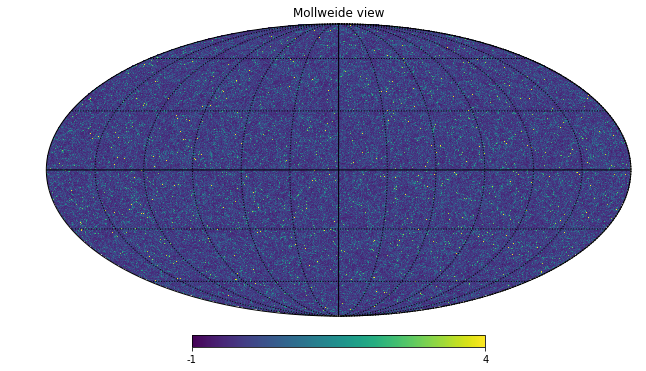

In [4]:
density_field_buzzard = hp.fitsfunc.read_map('../data/Buzzard_data/oliver_delta.fits')

nside = 2048

plt.figure(figsize=(12,12))
hp.mollview(density_field_buzzard, min=-1, max=4)
hp.graticule()
plt.savefig('./buzzard_output/plot_output/density_field_buzzard_map.pdf')

# Make a single patch of pixels and save with astropy (fits) for feeding into treecorr

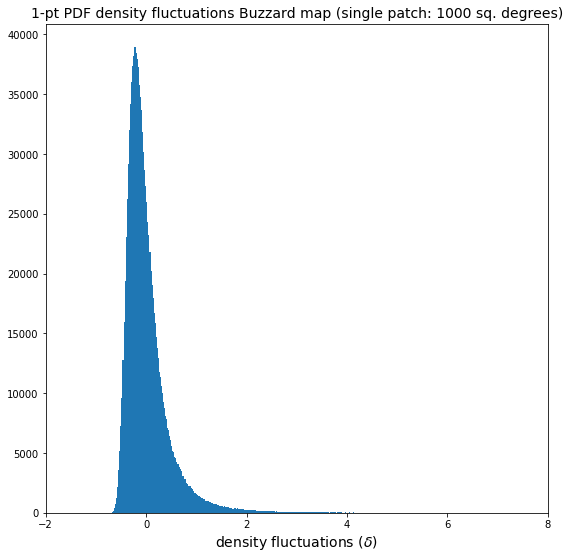

In [5]:
# Choose a random pixel i.e. center of disc (patch on the sky map) around which to take 1000 deg square area
disc_center = hp.pix2vec(nside, 1010101)

# radius (in radians) corresponding to 1000 deg square patch in sky = 0.31 radians

# find the pixels 
pixels_indices_disc = hp.query_disc(nside, disc_center, 0.31)

density_field_buzzard_disc = density_field_buzzard[pixels_indices_disc]
dec = np.pi/2 - hp.pix2ang(nside, pixels_indices_disc)[0]
RA = hp.pix2ang(nside, pixels_indices_disc)[1]

# for saving into fits file with astropy
RA_data = Column(RA, name='RA', dtype='float') # column having ra
dec_data = Column(dec, name='dec', dtype='float') # column having dec
del_data = Column(density_field_buzzard_disc, name='del', dtype='float') # column having pixels_disc_values

density_fluctuations_table = Table((RA_data, dec_data, del_data))  
# density_fluctuations_table.show_in_notebook()

density_fluctuations_table.write("./buzzard_output/single_patch/density_fluctuations_buzzard_single_patch.fits" , overwrite=True)

# 1-pt PDF of density fluctuations within patch

plt.figure(figsize=(9,9))
plt.hist(density_field_buzzard_disc, bins=1000)
plt.xlabel('density fluctuations ($δ$)', fontsize=14)
plt.xlim(-2,8)
plt.title('1-pt PDF density fluctuations Buzzard map (single patch: 1000 sq. degrees)', fontsize=14)
plt.savefig("./buzzard_output/plot_output/1_pt_PDF_single_patch/density_fluctuations_buzzard_1_pt_PDF_single_patch.pdf")

# TreeCorr: for autocorrelation of the Buzzard density fluctuations

In [6]:
density_fluctuations = hp.read_cl('./buzzard_output/single_patch/density_fluctuations_buzzard_single_patch.fits')

density_fluctuations_RA = density_fluctuations[0,:]
density_fluctuations_dec = density_fluctuations[1,:]
density_fluctuations_del = density_fluctuations[2,:]

cat = treecorr.Catalog(ra=density_fluctuations_RA, dec=density_fluctuations_dec,
                       ra_units='rad', dec_units='rad', k=density_fluctuations_del)

kk = treecorr.KKCorrelation(min_sep=1, max_sep=300, nbins=20, sep_units='arcmin')
kk.process(cat) 
theta_tc = kk.meanr
w_tc = kk.xi

dat = np.array([theta_tc, w_tc])
dat = dat.T
np.savetxt('./buzzard_output/single_patch/treecorr_angular_correlation_buzzard_single_patch.txt', dat, delimiter = ' ')

# Comparison of $w(\theta)$ from treecorr and from theoretical halofit $C_l$

In [7]:
def w_theta(theta):
    x = np.cos(theta)
    coeff = (2*l+1)/(4*np.pi)*cl
    w = np.polynomial.legendre.legval(x, coeff)
    return w     

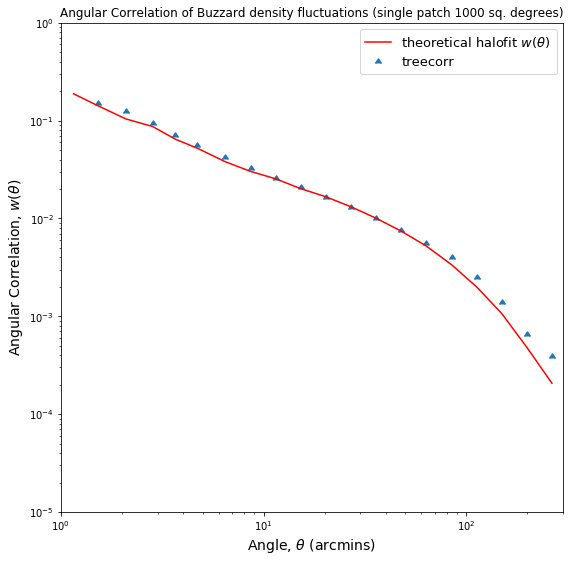

In [11]:
theta_treecorr = np.loadtxt('./buzzard_output/single_patch/treecorr_angular_correlation_buzzard_single_patch.txt', usecols=(0)) # in arcmins
w_treecorr = np.loadtxt('./buzzard_output/single_patch/treecorr_angular_correlation_buzzard_single_patch.txt', usecols=(1)) # w(theta)

plt.figure(figsize=(9,9))
plt.scatter(theta_treecorr,w_treecorr, marker=10, label='treecorr')
plt.plot(theta_treecorr, w_theta(theta_treecorr/60*np.pi/180), c='r', label='theoretical halofit $w(θ)$')
plt.xlim(1,300)
plt.ylim(1e-5, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angle, $θ$ (arcmins)', fontsize=14)
plt.ylabel('Angular Correlation, $w(θ)$', fontsize=14)
plt.title('Angular Correlation of Buzzard density fluctuations (single patch 1000 sq. degrees)')
plt.legend(fontsize=13)
plt.savefig('./buzzard_output/plot_output/treecorr_and_theoretical_angular_correlation_buzzard_single_patch.pdf')